In [ ]:
%%capture
!pip install -U numpy==1.23.1 shap lime # need a restart after the run

In [ ]:
import pandas as pd
import numpy as np
import graphviz

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline


from xgboost import XGBClassifier

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import shap

from lime import lime_tabular

import warnings
warnings.simplefilter('ignore')

In [ ]:
def plot_coefficients(model, columns):
    coefs = pd.DataFrame(data=model.coef_.reshape(-1, 1), index=columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')

### Данные

In [ ]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
target = 'Class'
predictors = [
    'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
    'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
    'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'
]

In [ ]:
train_df, test_df = train_test_split(df, stratify=df[target], test_size=0.2, random_state=2024)

### Logistic Regression

In [ ]:
lr_pipe = make_pipeline(StandardScaler(), LogisticRegression())
lr_pipe.fit(train_df[predictors], train_df[target])
print(f'ROC AUC: {roc_auc_score(test_df[target], lr_pipe.predict_proba(test_df[predictors])[:, 1])}')
print(classification_report(test_df[target], lr_pipe.predict(test_df[predictors])))

ROC AUC: 0.9821547006534748
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.56      0.67        98

    accuracy                           1.00     56962
   macro avg       0.92      0.78      0.84     56962
weighted avg       1.00      1.00      1.00     56962



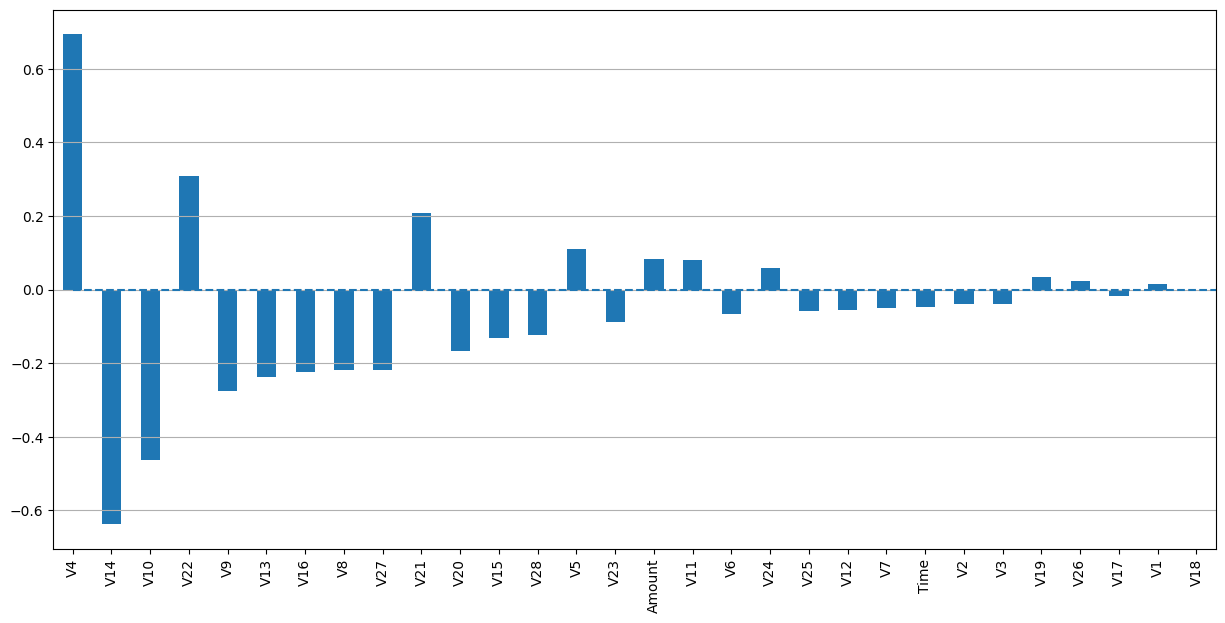

In [ ]:
plot_coefficients(lr_pipe.named_steps['logisticregression'], train_df[predictors].columns)

### Decision Tree

In [ ]:
tree_model = DecisionTreeClassifier()
tree_model.fit(train_df[predictors], train_df[target])
print(f'ROC AUC: {roc_auc_score(test_df[target], tree_model.predict_proba(test_df[predictors])[:, 1])}')
print(classification_report(test_df[target], tree_model.predict(test_df[predictors])))

ROC AUC: 0.8671534947687572
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.77      0.73      0.75        98

    accuracy                           1.00     56962
   macro avg       0.88      0.87      0.87     56962
weighted avg       1.00      1.00      1.00     56962



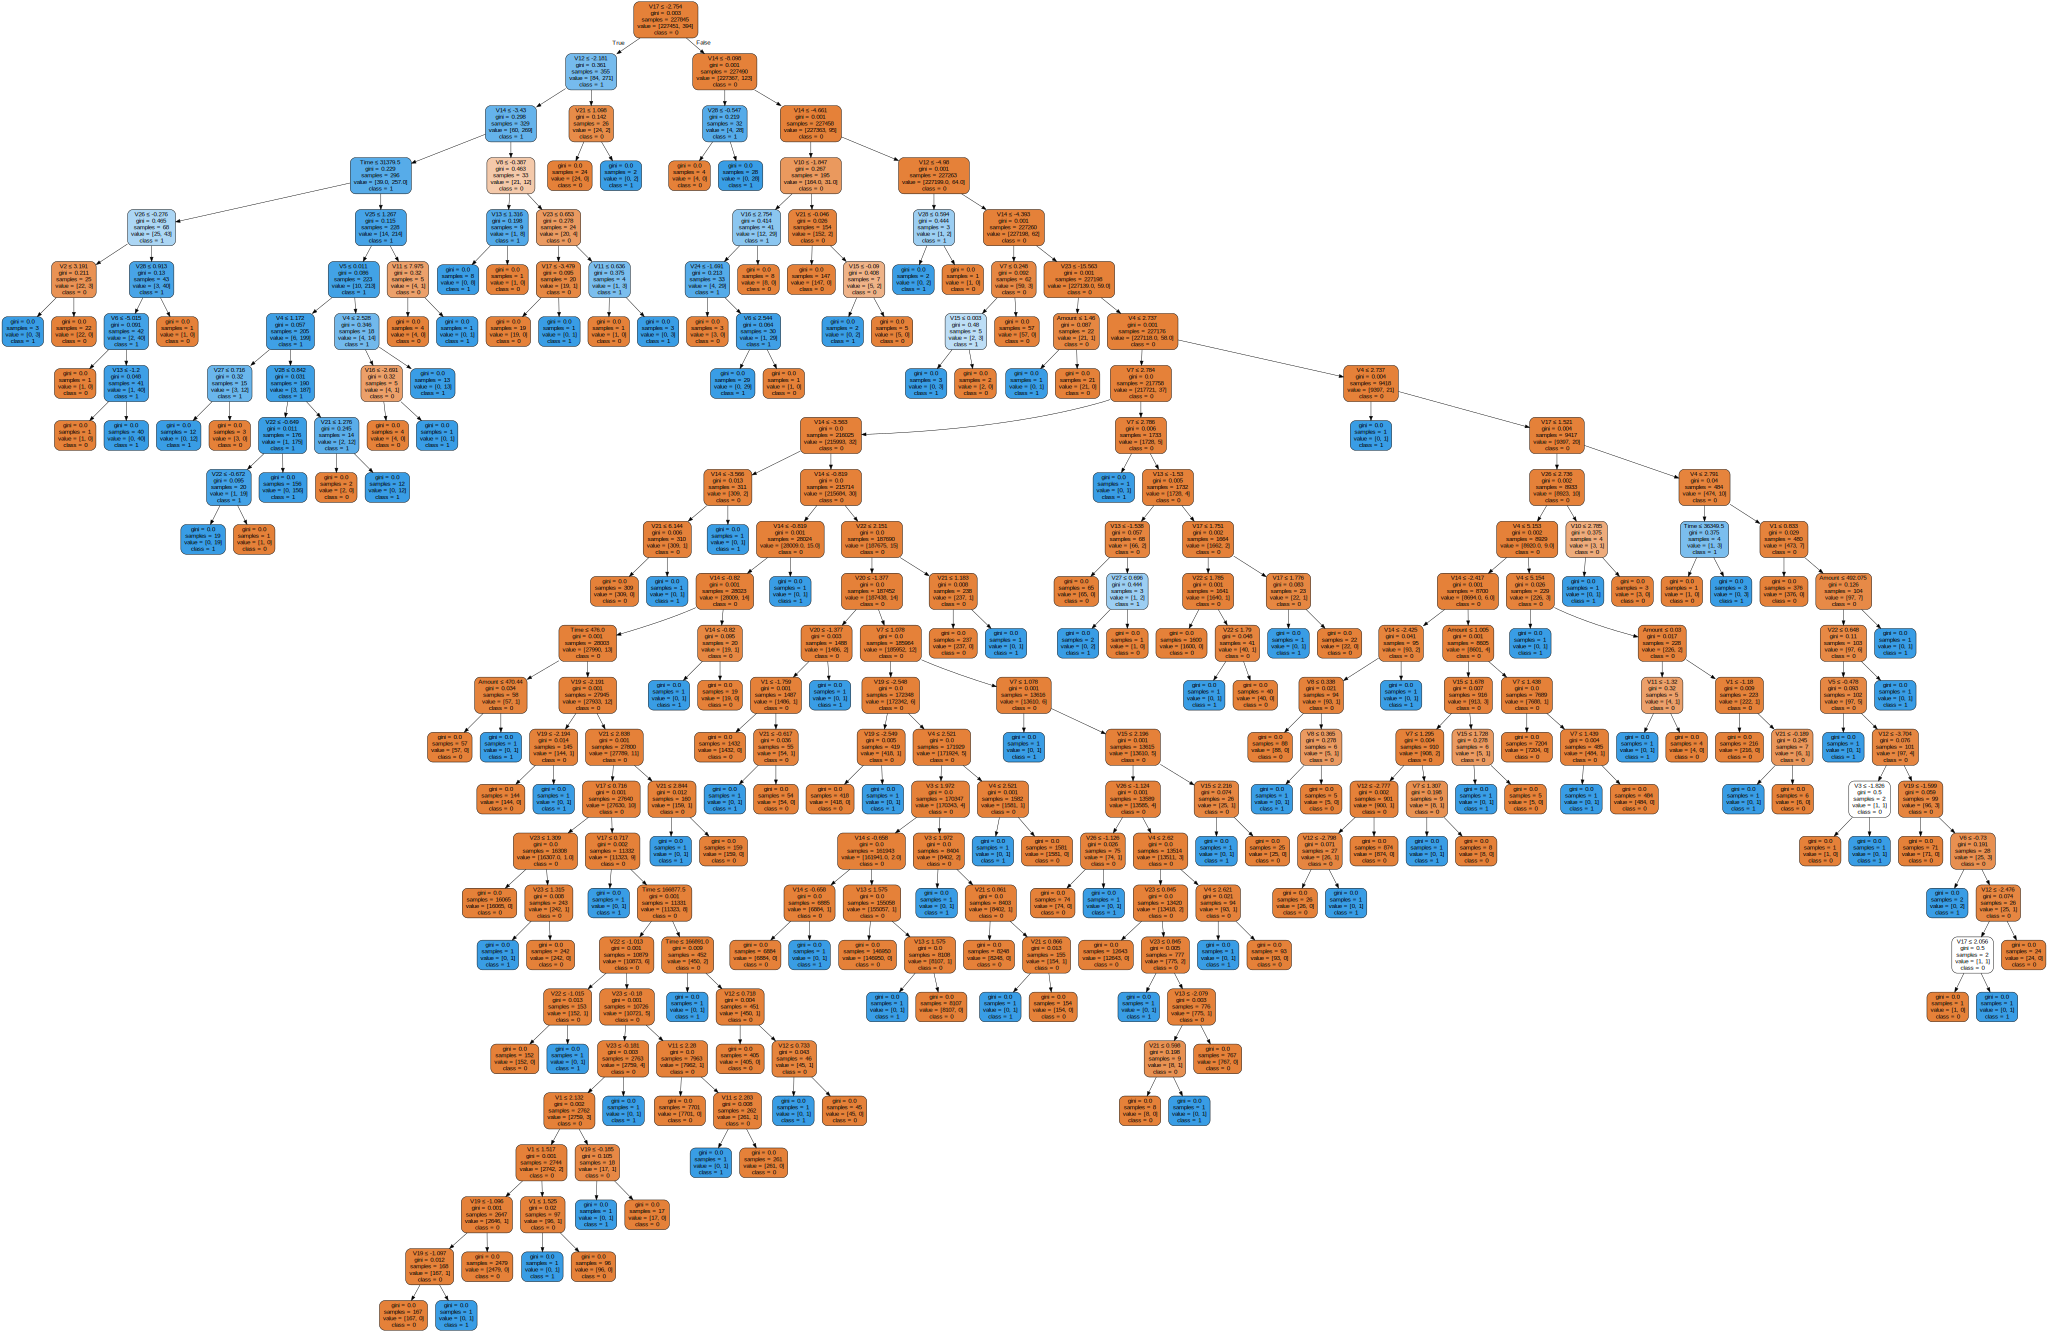

In [ ]:
dot_data = export_graphviz(
  tree_model, out_file=None,
  feature_names=train_df[predictors].columns,
  class_names=["0", "1"],
  filled=True, rounded=True,
  special_characters=True
)
graph = graphviz.Source(dot_data)
graph

### Случайный лес

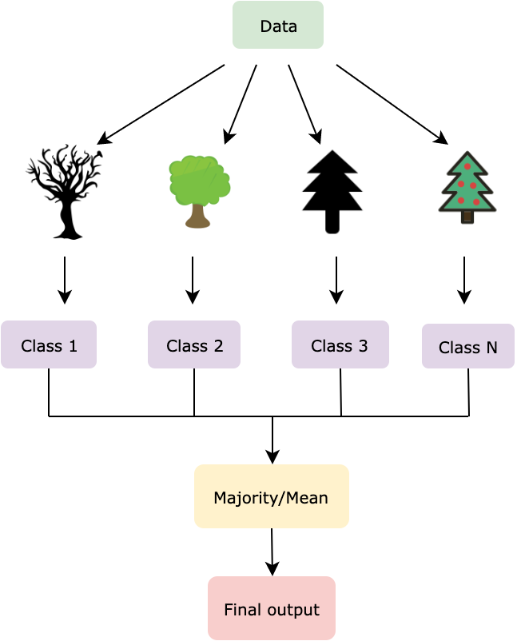

In [ ]:
rf_model = RandomForestClassifier(random_state=2024, n_estimators=50)
rf_model.fit(train_df[predictors], train_df[target])
print(f'ROC AUC: {roc_auc_score(test_df[target], rf_model.predict_proba(test_df[predictors])[:, 1])}')
print(classification_report(test_df[target], rf_model.predict(test_df[predictors])))

ROC AUC: 0.9480791261355415
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.92      0.74      0.82        98

    accuracy                           1.00     56962
   macro avg       0.96      0.87      0.91     56962
weighted avg       1.00      1.00      1.00     56962



### Бустинг

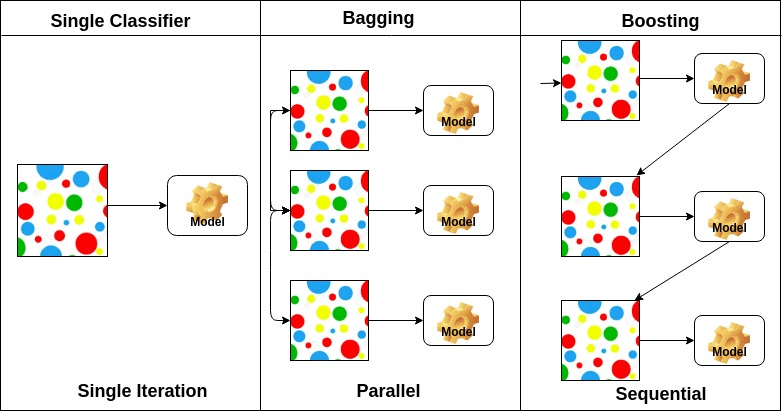

In [ ]:
xgb_model = XGBClassifier(random_state=2024, n_estimators=50)
xgb_model.fit(train_df[predictors], train_df[target])
print(f'ROC AUC: {roc_auc_score(test_df[target], xgb_model.predict(test_df[predictors]))}')
print(classification_report(test_df[target], xgb_model.predict(test_df[predictors])))

ROC AUC: 0.8622361050497859
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.99      0.72      0.84        98

    accuracy                           1.00     56962
   macro avg       0.99      0.86      0.92     56962
weighted avg       1.00      1.00      1.00     56962



## Интерпретация моделей

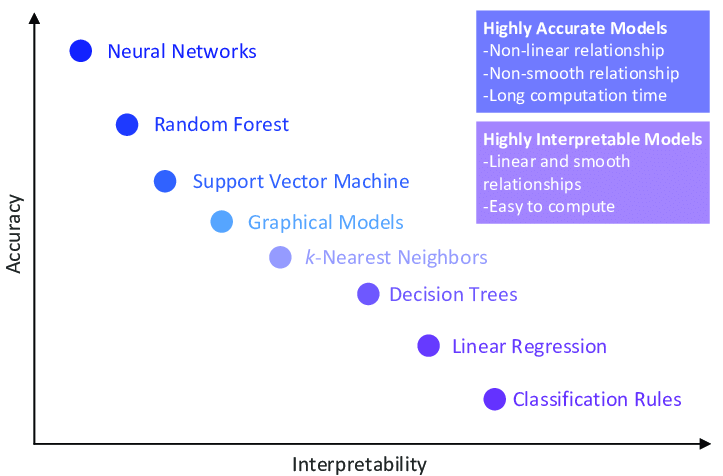

#### Mean Decrease in Impurity

- Основывается на среднем уменьшении информационного критерия при разбиении.

- Основная идея - признаки, используемые в верхней части дерева, влияют на окончательное предсказание для большей доли обучающих объектов, чем признаки, попавшие на более глубокие уровни

- Для всех правил в дереве, использующих признак, считаем уменьшение информационного критерия, суммируем, и усредняем по всем деревьям

- Если присмотреться, в этом способе числовые признаки и категориальные признаки с высокой кардинальностью ранжируются как более важные :с (почему?)

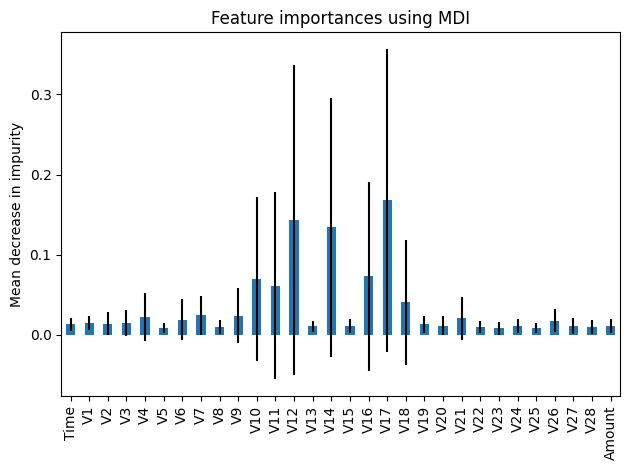

In [ ]:
forest_importances = pd.Series(rf_model.feature_importances_, index=train_df[predictors].columns)

fig, ax = plt.subplots()
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity", )
fig.tight_layout()

#### Permutation importances

Случайным образом перемешиваем данные по одному признаку за раз и смотрим на изменение целевой метрики


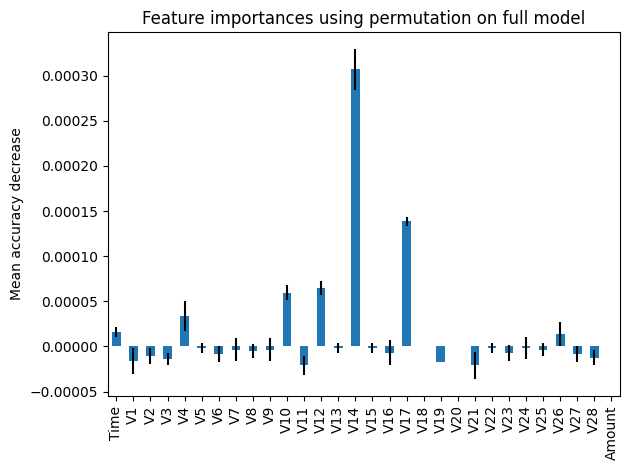

In [ ]:
importances = permutation_importance(rf_model, test_df[predictors], test_df[target], n_repeats=10, random_state=2023, n_jobs=2)
forest_importances = pd.Series(importances.importances_mean, index=test_df[predictors].columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=importances.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Важность признаков может сильно зависеть от особенностей распределения данных, а это распределение может отличаться при обучении и инференсе :с

А еще

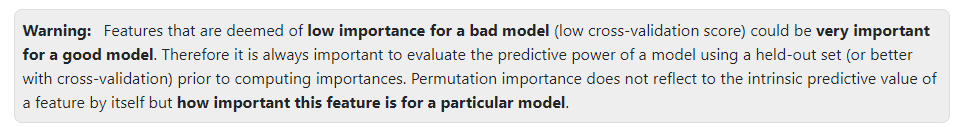

#### LIME

[lime - репозиторий](https://github.com/marcotcr/lime)

- Исходная **точка**, для которой требуется интерпретация, выбирается из набора данных.
- Эта точка служит центром локального анализа и основой для генерации новых, возмущенных примеров данных (бутстрап, случайный шум etc).
- Каждый возмущенный пример получает вес, основанный на его близости к исходной точке.
- Используя этот взвешенный набор данных, обучается простая интерпретируемая модель (например, линейная модель). Эта модель стремится приблизить предсказания сложной модели в локальной области, окружающей исходную точку.
- Анализируя, как меняются предсказания в ответ на возмущения, можно получить представление о том, какие факторы влияют на решения модели.


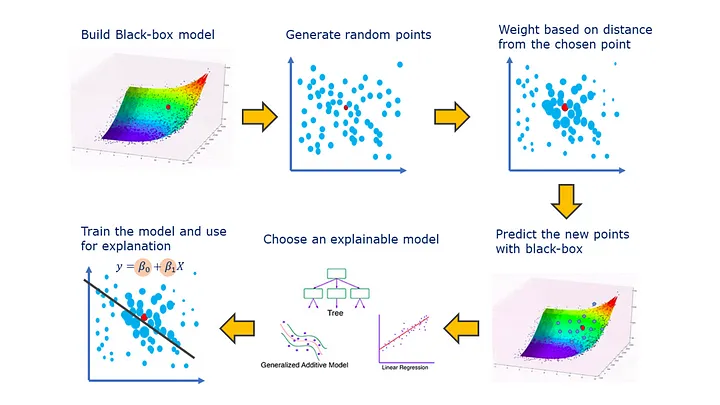

Результаты LIME являются локальными, то есть они объясняют предсказание модели для конкретного примера или наблюдения, а не для всего набора данных.

In [ ]:
for i in range(600, 700):
  print(f'{i} {rf_model.predict_proba(test_df[predictors].iloc[i].values.reshape(1, -1))}')

600 [[0.06 0.94]]
601 [[1. 0.]]
602 [[1. 0.]]
603 [[1. 0.]]
604 [[1. 0.]]
605 [[1. 0.]]
606 [[1. 0.]]
607 [[1. 0.]]
608 [[1. 0.]]
609 [[1. 0.]]
610 [[1. 0.]]
611 [[1. 0.]]
612 [[1. 0.]]
613 [[1. 0.]]
614 [[1. 0.]]
615 [[1. 0.]]
616 [[1. 0.]]
617 [[1. 0.]]
618 [[1. 0.]]
619 [[1. 0.]]
620 [[1. 0.]]
621 [[1. 0.]]
622 [[1. 0.]]
623 [[1. 0.]]
624 [[1. 0.]]
625 [[1. 0.]]
626 [[1. 0.]]
627 [[1. 0.]]
628 [[1. 0.]]
629 [[1. 0.]]
630 [[1. 0.]]
631 [[1. 0.]]
632 [[1. 0.]]
633 [[1. 0.]]
634 [[1. 0.]]
635 [[1. 0.]]
636 [[1. 0.]]
637 [[1. 0.]]
638 [[1. 0.]]
639 [[1. 0.]]
640 [[1. 0.]]
641 [[1. 0.]]
642 [[1. 0.]]
643 [[1. 0.]]
644 [[1. 0.]]
645 [[1. 0.]]
646 [[1. 0.]]
647 [[1. 0.]]
648 [[1. 0.]]
649 [[1. 0.]]
650 [[0.98 0.02]]
651 [[1. 0.]]
652 [[1. 0.]]
653 [[1. 0.]]
654 [[1. 0.]]
655 [[1. 0.]]
656 [[1. 0.]]
657 [[1. 0.]]
658 [[1. 0.]]
659 [[1. 0.]]
660 [[1. 0.]]
661 [[1. 0.]]
662 [[1. 0.]]
663 [[1. 0.]]
664 [[1. 0.]]
665 [[1. 0.]]
666 [[1. 0.]]
667 [[1. 0.]]
668 [[1. 0.]]
669 [[1. 0.]]
670 [[1. 0.]

In [ ]:
explainer = lime_tabular.LimeTabularExplainer(
    train_df[predictors].values,
    feature_names=train_df[predictors].columns,
    training_labels=train_df[target],
    verbose=True,
    mode='classification',
)
i = 600
exp = explainer.explain_instance(test_df[predictors].iloc[i].values, rf_model.predict_proba, num_features=20);

Intercept -0.006455299269522286
Prediction_local [0.04074178]
Right: 0.94


In [ ]:
exp.show_in_notebook(show_table=True)

В случае линейной модели коэффициенты могут быть положительными или отрицательными, указывая на то, как признак влияет на предсказание (положительно или отрицательно). Величина коэффициентов указывает на степень важности признаков. Большие абсолютные значения коэффициентов свидетельствуют о большем вкладе признака в предсказание.

In [ ]:
exp.as_list()

[('V17 <= -0.48', 0.00570963050987148),
 ('V14 <= -0.42', 0.004076940644944211),
 ('V4 > 0.74', 0.003159526530872447),
 ('V10 <= -0.54', 0.0029510432324796484),
 ('V8 > 0.33', 0.002814610235082456),
 ('V12 <= -0.40', 0.0028020888297576427),
 ('Amount <= 5.60', 0.0025007699722586),
 ('Time <= 54262.00', 0.0023990805578127895),
 ('V26 > 0.24', 0.002380130219320309),
 ('V2 > 0.80', 0.0023366855205353165),
 ('V11 > 0.74', 0.0018828662932521424),
 ('V18 <= -0.50', 0.0018239809313292078),
 ('V6 <= -0.77', 0.001752755590243824),
 ('V28 > 0.08', 0.0017433190341494473),
 ('0.02 < V25 <= 0.35', 0.0016502247053228212),
 ('V21 > 0.19', 0.0016055824966000867),
 ('V27 > 0.09', 0.0015593549263300634),
 ('V9 <= -0.64', 0.0014069275700582628),
 ('V24 > 0.44', 0.001342545433776382),
 ('V3 <= -0.89', 0.0012990147118828474)]

##### Проблемы?



- Генерация и взвешивание точек - узкое место

- Слабое научное обоснование

#### SHAP

[Документация](https://shap.readthedocs.io/en/latest/)

Доступна локальная и глобальная интерпретация


- Создаются коалиции - подмножества всех доступных признаков в наборе данных.

- Для каждого наблюдения создаются все возможные комбинации признаков. Это включает сценарии, где некоторые признаки присутствуют, а некоторые отсутствуют.

- Для набора из N признаков, это означает создание (2^N) различных подмножеств, включая пустое множество (где отсутствуют все признаки) и полное множество (где присутствуют все признаки).

- Для каждой коалиции признаков вычисляется вклад признака, который оценивает, насколько изменяется предсказание модели при добавлении этого признака к коалиции.

- Производится перебор всех возможных коалиций признаков, и для каждой из них вычисляется, как изменится предсказание модели при добавлении рассматриваемого признака.

- Вычисляется среднее взвешенное влияние признака на предсказание модели, учитывая все возможные коалиции. Это среднее и является значением Шепли для данного признака.

- Значения Шепли для всех признаков суммируются для каждого наблюдения, чтобы оценить их коллективный вклад в предсказание модели.

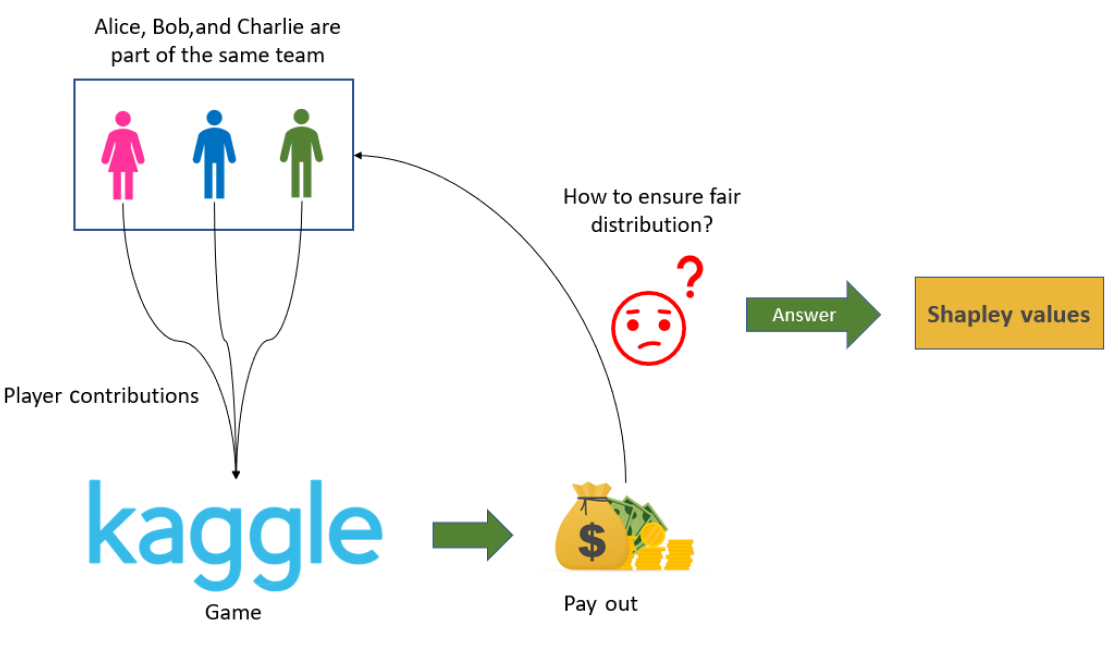

Локальные интерпретации

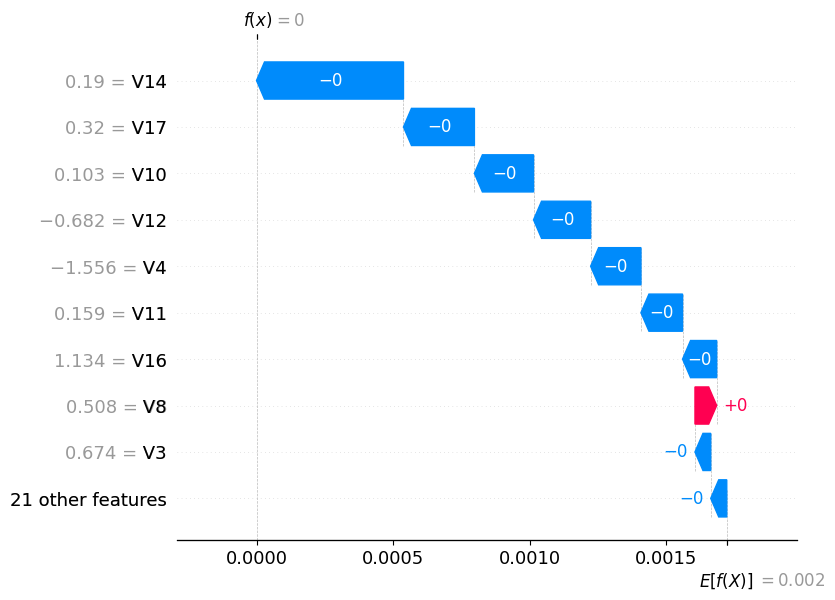

In [ ]:
explainer = shap.Explainer(rf_model)
X = test_df[predictors].head(300)
shap_values = explainer(X)[:, :, 1]

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.initjs()
shap.plots.force(shap_values[0])

Глобальные

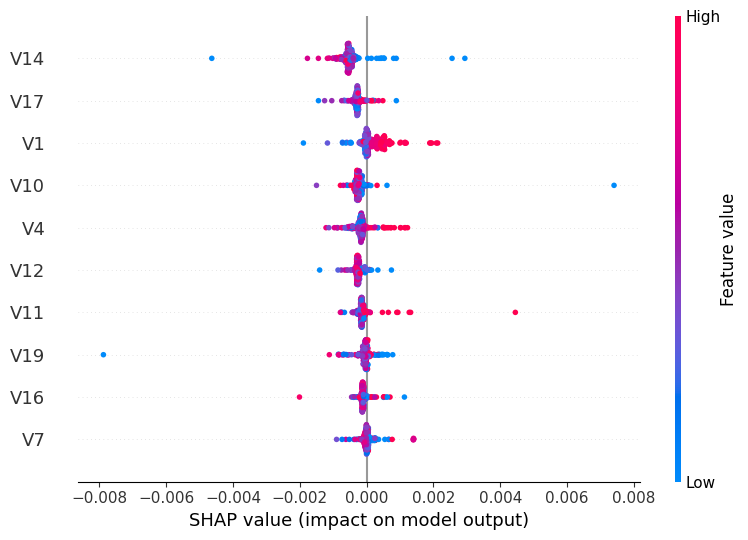

In [ ]:
shap.summary_plot(shap_values, X, max_display=10)

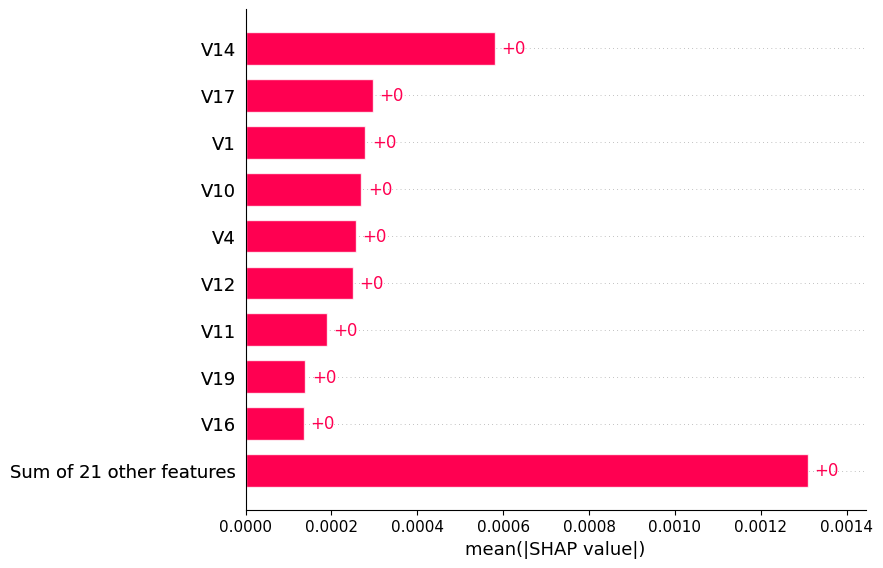

In [ ]:
shap.plots.bar(shap_values, max_display=10)

##### Проблемы?



- Высокая вычислительная сложность, используются аппроксимации
- При небольшой исходной выборке лучше использовать не обобщающий SHAP-подход, а локальный метод LIME
